In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mth
import warnings

from scipy import stats as st
from scipy.stats import beta
from calc_prob import calc_prob_between

warnings.filterwarnings('ignore')
#%matplotlib inline
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 120

# Введение

Нужно разобраться, как ведут себя пользователи мобильного приложения-магазина продуктов питания, изучить воронку продаж, узнать, сколько пользователей доходит до покупки, а сколько — нет

Также исследовать результаты A/A/B-эксперимента по изменению шрифта, у нас есть две контрольных и одна экспериментальная группа

<div class="alert alert-success">
<b>Комментарии ревьюера:</b> Молодец, что сделал краткое описание контекста задачи. Можно еще поработать над введением - выделить цель, сделать описание входных переменных и план работы. </div>

# Общая информация

In [3]:
try:
    from paths import aab_project_path

    df = pd.read_csv(aab_project_path)
except ModuleNotFoundError:
    print('Data not for public use, sorry')
    raise

In [4]:
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='s')
df['date'] = df['event_timestamp'].astype('datetime64[D]')

df.head(1)

,event_name,device_id,event_timestamp,group_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   device_id        244126 non-null  int64         
 2   event_timestamp  244126 non-null  datetime64[ns]
 3   group_id         244126 non-null  int64         
 4   date             244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [6]:
df[df.duplicated()]

,event_name,device_id,event_timestamp,group_id,date
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248,2019-07-30
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248,2019-07-31
3573,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248,2019-08-01
4076,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,247,2019-08-01
4803,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,248,2019-08-01
...,...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,2019-08-07 19:26:44,247,2019-08-07
242332,PaymentScreenSuccessful,4718002964983105693,2019-08-07 19:26:45,247,2019-08-07
242360,PaymentScreenSuccessful,2382591782303281935,2019-08-07 19:27:29,246,2019-08-07
242362,CartScreenAppear,2382591782303281935,2019-08-07 19:27:29,246,2019-08-07


Привели названия столбцов к удобному виду, привели дату к корректному формату;  
Явных пропусков (NaN'ов) в данных нет, дубли есть (413), но на наш анализ влияния не окажут, мы оперируем уникальными юзерами


# Первичный анализ

## Всего событий в логе

In [7]:
df.shape

(244126, 5)

244126 записи

## Всего пользователей в логе


In [8]:
df['device_id'].nunique()

7551

7551 уникальных устройств, про юзеров точно сказать не можем, но будем считать, что множества равны  

## Событий на пользователя


In [9]:
tdf = df.groupby('device_id').agg({'event_name': 'count'}).reset_index()

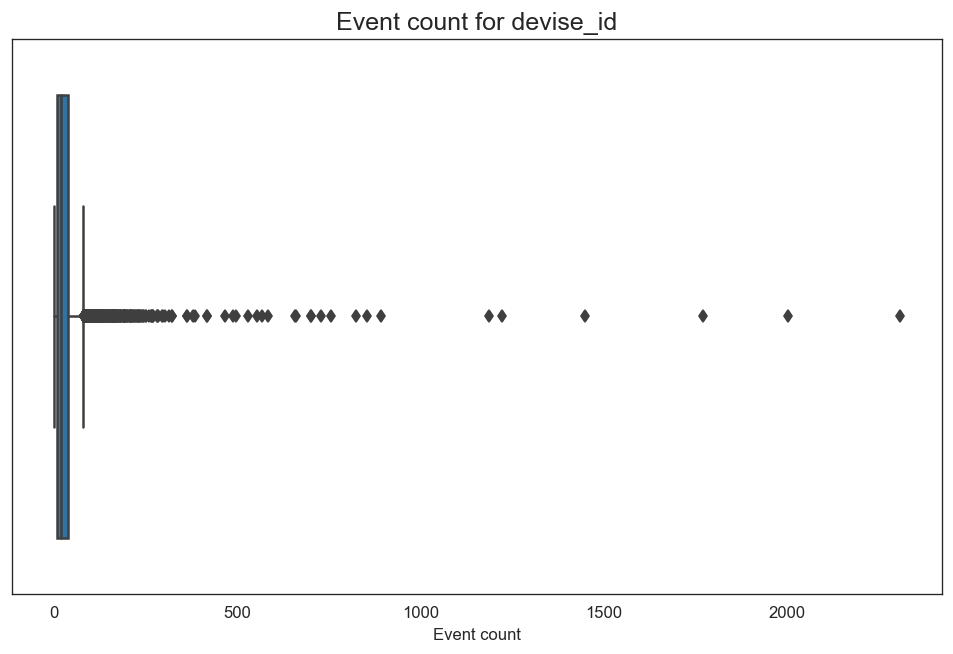

In [10]:
sns.set_style("white")

plt.figure(figsize=(10, 6), dpi=120)

sns.boxplot(x=tdf["event_name"])

plt.title('Event count for devise_id', fontsize=15)
plt.xlabel("Event count")
plt.ylabel("")
plt.show()

In [11]:
tdf.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["event_name"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
event_name,7551.0,32.330287,65.312344,1.0,1.0,3.0,5.0,8.0,20.0,43.0,64.0,89.0,200.5,2308.0


99% id у нас сделали за наблюдаемый период 200 и меньше действий, при этом мксимум - 2308  
Эти выбросы могут помешать нам адекватно оценить результаты теста, отбросим этот один процент

In [12]:
normal_users = tdf.query('event_name <= 200')['device_id']

In [13]:
df = df.query('device_id in @normal_users')

In [14]:
df.shape

(209658, 5)

Записей в нашем логе осталось 209658

In [15]:
tdf = df.groupby('device_id').agg({'event_name': 'count'}).reset_index()

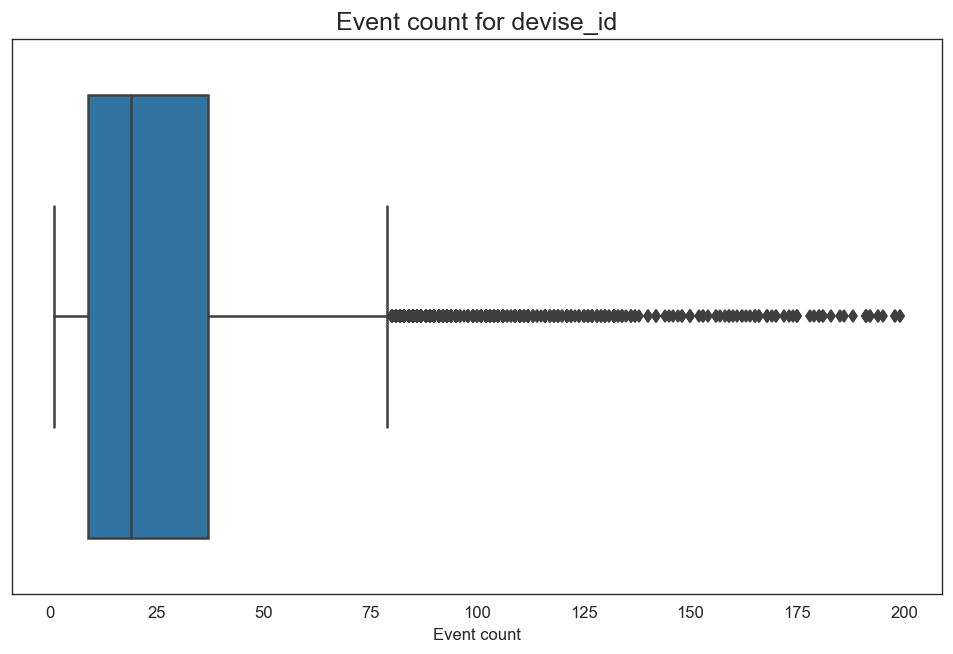

In [16]:
plt.figure(figsize=(10, 6), dpi=120)

sns.boxplot(x=tdf["event_name"])

plt.title('Event count for devise_id', fontsize=15)
plt.xlabel("Event count")
plt.ylabel("")
plt.show()

In [17]:
tdf.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["event_name"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
event_name,7475.0,28.047893,27.848002,1.0,1.0,3.0,5.0,8.0,19.0,42.0,62.0,83.0,136.0,199.0


Теперь график можно прочитать: медиана 19, среднее 28, то есть типичный пользователь оставил в логе записи о девятнадцати действиях


## Таймлайн эксперимента

In [18]:
df['event_timestamp'].describe()

count                  209658
unique                 156983
top       2019-08-04 16:23:19
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:15:17
Name: event_timestamp, dtype: object

У нас есть данные с 2019-07-25 по 2019-08-07, посмотрим, сколь полные  
Сгруппируем по часам, посмотрим на графике


In [19]:
df['event_timestamp_h'] = df['event_timestamp'].dt.round(freq='H')
df['event_timestamp_h'] = df['event_timestamp_h'].dt.strftime('%m-%d-%H')

In [20]:
tdf = df.groupby('event_timestamp_h').agg({'date': 'count'}).reset_index()

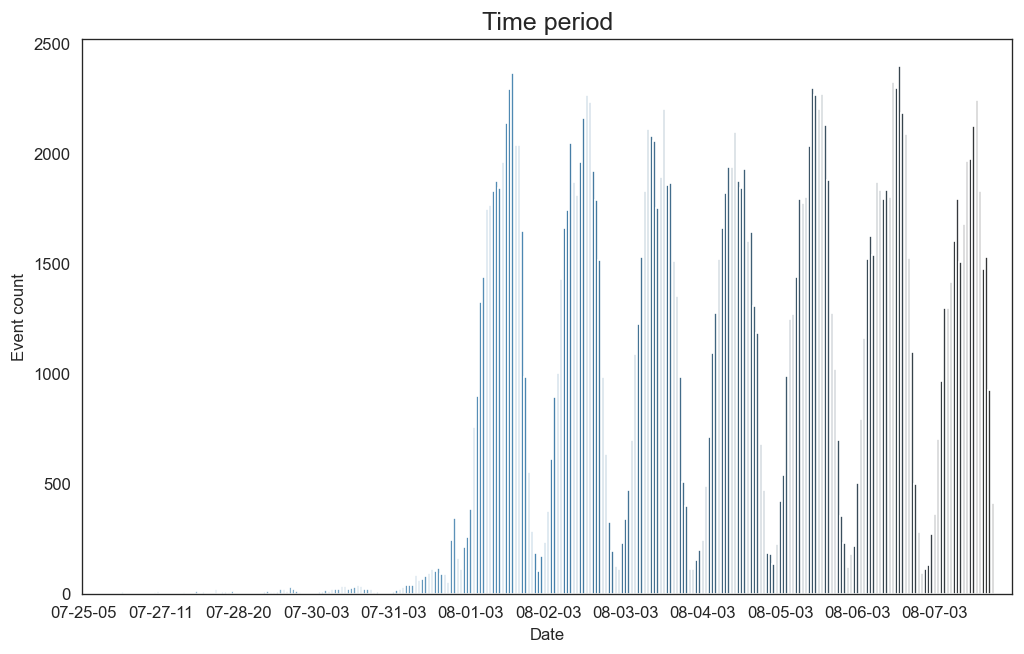

In [21]:
plt.figure(figsize=(10, 6), dpi=120)

sns.barplot(x="event_timestamp_h", y="date", data=tdf, palette="Blues_d")

#plt.yscale('log')
plt.xticks(np.arange(0, 310, step=24))
plt.title('Time period', fontsize=15)
plt.xlabel("Date")
plt.ylabel("Event count")
plt.show()

Видно, что у нас полно артефактов, которые увеличили рельную продолжительность
теста примерно вдвое  
Посмотрим на участок между 31.07 и 02.08

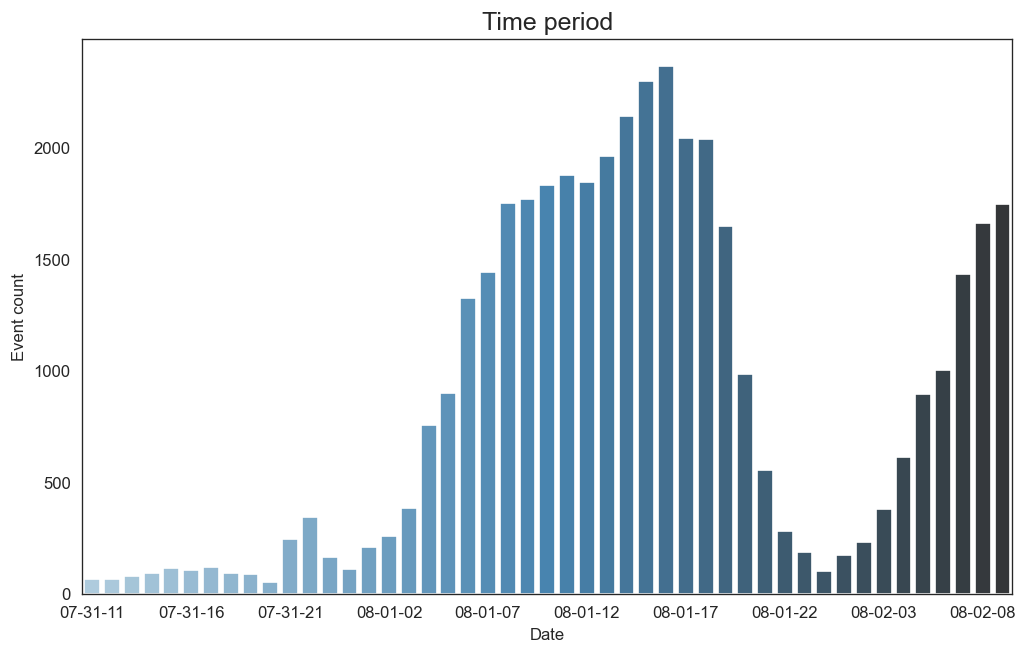

In [22]:
plt.figure(figsize=(10, 6), dpi=120)

sns.barplot(x="event_timestamp_h", y="date",
            data=tdf.query('event_timestamp_h > "07-31-10" and event_timestamp_h < "08-02-10"'),
            palette="Blues_d")

#plt.yscale('log')
plt.xticks(np.arange(0, 48, step=5))
plt.title('Time period', fontsize=15)
plt.xlabel("Date")
plt.ylabel("Event count")
plt.show()

Видно, что 01.08 тест уже запущен в полную силу, запуск, судя по данным,
начался между 21 и 22 часами 31.07. Поставим как время начала 22:00 31.07,
более ранние данные отбросим

In [23]:
(df.shape[0] - df.query('event_timestamp_h > "07-31-22"').shape[0]) / df.shape[0] * 100

1.2057732116112907

In [24]:
(df.shape[0] - df.query('event_timestamp_h > "07-31-22"').shape[0])

2528

Всего выбросим 2528 строк, 1.2% датасета

In [25]:
abs(df.query('event_timestamp_h > "07-31-22"')['device_id'].nunique()
    - df['device_id'].nunique()) / df['device_id'].nunique() * 100

0.18729096989966557

In [26]:
(df.query('event_timestamp_h > "07-31-22"')['device_id'].nunique()
 - df['device_id'].nunique())

-14

И потеряем 14 уников, 0.19% от всего количества

In [27]:
df = df.query('event_timestamp_h > "07-31-22"')

In [28]:
df.groupby('group_id').agg({'date': 'count'})

,date
group_id,
246,67568
247,68492
248,71070


Количество событий в логе по трём нашим группам распределено достаточно корректно 


# Воронка событий

## События в логе и их частота


In [29]:
event_count = (df.groupby('event_name')
               .agg({'device_id': 'count'})
               .reset_index()
               .sort_values('device_id', ascending=False))
event_count.rename(columns={'device_id': 'event_count'}, inplace=True)
event_count

,event_name,event_count
1,MainScreenAppear,113509
2,OffersScreenAppear,41012
0,CartScreenAppear,29298
3,PaymentScreenSuccessful,22295
4,Tutorial,1016


Пять видов событий, количество ивентов для каждого в таблице

## Уникальные пользователи в разрезе событий 
Посмотрим, какой процент пользователей совершил действие для каждого события

In [30]:
user_per_event_count = (df.groupby('event_name')
                        .agg({'device_id': 'nunique'})
                        .reset_index()
                        .sort_values('device_id', ascending=False))
user_per_event_count.rename(columns={'device_id': 'user_per_event_count'},
                            inplace=True)
user_per_event_count['share_of_users'] = (user_per_event_count['user_per_event_count']
                                          / df['device_id'].nunique())
user_per_event_count

,event_name,user_per_event_count,share_of_users
1,MainScreenAppear,7346,0.984587
2,OffersScreenAppear,4519,0.605683
0,CartScreenAppear,3659,0.490417
3,PaymentScreenSuccessful,3463,0.464147
4,Tutorial,825,0.110575


Четыре из пяти возможных ивентов, кроме туториала (что вообще такое обучение в приложении магазина?) выстраиваются по доле пользователей, совершивших данный ивент, в следущую цепочку:
главный экран - каталог - корзина - оплата.
Это наша воронка событий
Также 1.5% каким-то образом пропустили главный экран - возможно, сразу перешли к каталогу

Учитывать события группы `Tutorial` при анализе мы не будем, можно отбросить лишние строки

## Воронка событий

In [31]:
def show_values_on_bars(axs, h_v: str = "v", space: float = 10):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                try:
                    _x = p.get_x() + p.get_width() / 2
                    _y = p.get_y() + p.get_height()
                    value = int(p.get_height())
                    ax.text(_x, _y, value, ha="center")
                except ValueError:
                    pass
        elif h_v == "h":
            for p in ax.patches:
                try:
                    _x = p.get_x() + p.get_width() + float(space)
                    _y = p.get_y() + p.get_height() - 0.4
                    value = int(p.get_width())
                    ax.text(_x, _y, value, ha="left")
                except ValueError:
                    pass

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [32]:
user_per_event_count = user_per_event_count.query('event_name != "Tutorial"')

user_per_event_count['share_of_users_loss'] = (user_per_event_count['share_of_users'].shift(1) -
                                               user_per_event_count['share_of_users'])
user_per_event_count['share_of_previous'] = (user_per_event_count['user_per_event_count'] /
                                             user_per_event_count['user_per_event_count'].shift(1))
user_per_event_count

,event_name,user_per_event_count,share_of_users,share_of_users_loss,share_of_previous
1,MainScreenAppear,7346,0.984587,NaN,NaN
2,OffersScreenAppear,4519,0.605683,0.378904,0.615165
0,CartScreenAppear,3659,0.490417,0.115266,0.809692
3,PaymentScreenSuccessful,3463,0.464147,0.026270,0.946433


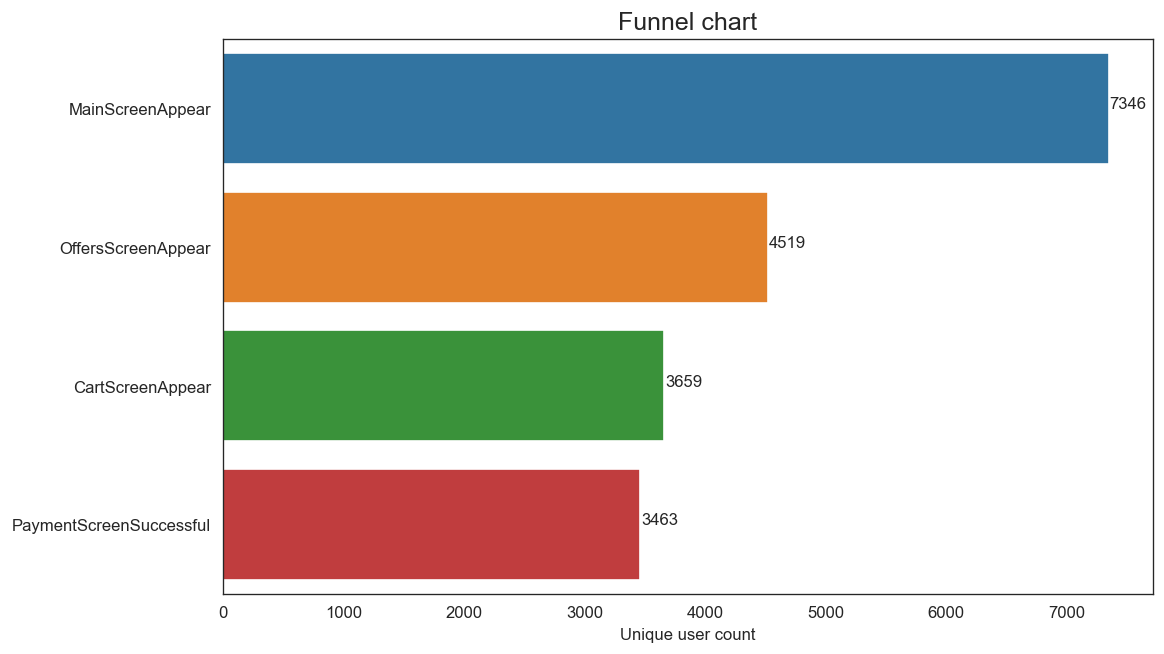

In [33]:
plt.figure(figsize=(10, 6), dpi=120)

show_values_on_bars(sns.barplot(data=user_per_event_count,
                                x='user_per_event_count',
                                y='event_name',
                                orient='h'),
                    h_v='h')

plt.title('Funnel chart', fontsize=15)
plt.xlabel("Unique user count")
plt.ylabel("")
plt.show()

На воронке событий видно, что больше всего пользователей (37.9%) мы теряем на первом шаге - на переходе с главного экрана на каталог, с каталога на корзину 11.5, с корзины в оплату 2.6%

**Всего до оплаты доходит 46.4% юзеров**

# Анализ результатов теста
Построим воронки для каждой тестовой группы и для объединённой контрольной  
**246, 247 - контроль, 248 - эксперимент**

In [34]:
groups = {'A1': 246,
          'A2': 247,
          'B': 248,
          'AA': [246, 247]}

conversion_funnel = (df.query('event_name != "Tutorial"')
                     .groupby('event_name')
                     .agg({'device_id': 'nunique'})
                     .reset_index()
                     .sort_values('device_id', ascending=False))

conversion_funnel.rename(columns={'device_id': 'total_user_count'},
                         inplace=True)

cv = dict()
total = dict()
total['total_user_count'] = (df.query('event_name != "Tutorial"')['device_id'].nunique())

In [35]:
for name, id in groups.items():
    cv[name] = df.query('group_id == @id and event_name != "Tutorial"')
    total[f'{name}_user_count'] = cv[name]['device_id'].nunique()
    cv[name] = (cv[name].groupby('event_name')
                .agg({'device_id': 'nunique'})
                .reset_index()
                .sort_values('device_id', ascending=False))
    cv[name].rename(columns={'device_id': f'{name}_user_count'}, inplace=True)
    conversion_funnel = pd.merge(conversion_funnel, cv[name])

In [36]:
conversion_funnel

,event_name,total_user_count,A1_user_count,A2_user_count,B_user_count,AA_user_count
0,MainScreenAppear,7346,2423,2456,2467,4879
1,OffersScreenAppear,4519,1514,1500,1505,3014
2,CartScreenAppear,3659,1238,1217,1204,2455
3,PaymentScreenSuccessful,3463,1172,1136,1155,2308


In [37]:
total

{'total_user_count': 7457,
 'A1_user_count': 2455,
 'A2_user_count': 2493,
 'B_user_count': 2509,
 'AA_user_count': 4948}

Получили воронки по всем группам, явного отличия не видно, проверим
на статистическую значимость, используя z-test

Возьмём стандартный порог значимости в 0.05 и сделаем поправку
на множественное сравнение, учтя, что мы провели 16 тестов  
Используем метод Шидака

In [38]:
alpha = 1 - (1 - 0.05) ** (1 / 16)
alpha

0.0032006977101884937

0.0032, три десятых процента, очень низкое значение. Сложно поверить,
глядя на наши результаы, что будет что-то даже близкое

## Z-test

In [39]:
def z_test(trials1: float, trials2: float, successes1: float, successes2: float, a: float) -> str:
    """
    Z-test для сравнения долей двух выборок
    :param trials1: размер первой выборки
    :param trials2: размер второй выборки
    :param successes1: количество событий для первой выборки
    :param successes2: количество событий для второй выборки
    :param a: пороговое значение p-value
    :return: возвращает строку со значением p-value. Если значение меньше порогового, добавит в строку флаг 'insignificant',
    """
    p1 = successes1 / trials1
    p2 = successes2 / trials2
    p_comb = (successes1 + successes2) / (trials1 + trials2)
    z_value = ((p1 - p2) /
               mth.sqrt(p_comb * (1 - p_comb) * (1 / trials1 + 1 / trials2)))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    if p_value < a:
        return str(p_value)
    else:
        return f'{p_value} insignificant'

Запишем все пары групп, которые хотим протестировать

In [40]:
trails = [['A1_user_count', 'A2_user_count'],
          ['AA_user_count', 'B_user_count'],
          ['A1_user_count', 'B_user_count'],
          ['A2_user_count', 'B_user_count']]

In [41]:
for pair in trails:
    group1 = pair[0]
    group2 = pair[1]
    conversion_funnel[
        f'{group1.split("_")[0]}-{group2.split("_")[0]} p_value'
    ] = conversion_funnel.apply(lambda x: z_test(total[group1], total[group2], x[group1], x[group2], alpha), axis=1)

In [42]:
p_value_table = conversion_funnel.drop(['total_user_count',
                                        'A1_user_count',
                                        'A2_user_count',
                                        'B_user_count',
                                        'AA_user_count'], axis=1)
p_value_table

,event_name,A1-A2 p_value,AA-B p_value,A1-B p_value,A2-B p_value
0,MainScreenAppear,0.5878575578561582 insignificant,0.34636372762125256 insignificant,0.2814719389970719 insignificant,0.5903117705317396 insignificant
1,OffersScreenAppear,0.2791132644715939 insignificant,0.4376843899965954 insignificant,0.22374437294463578 insignificant,0.8940685622760409 insignificant
2,CartScreenAppear,0.25712258926801024 insignificant,0.18372599953684987 insignificant,0.08551270605955108 insignificant,0.5572588833477934 insignificant
3,PaymentScreenSuccessful,0.12576053673904508 insignificant,0.6172622011192976 insignificant,0.22875623127967426 insignificant,0.7404693910076248 insignificant


Таблицу следует читать так:
каждая ячейка — p-value сравнения доли пользователей двух групп, названных в столбце, дошедших до определённого этапа, где

нулевая гипотеза (H0) — доли пользователей равны,

альтернативная гипотеза (H1) — доли пользователей различаются

Важно, что в столбце `A1-A2 p_value` тестирование не показало значимого различия: это означает, что тест был проведён корректно, и мы можем доверять результатам в других группах
**Да, все наши проверки не першли порога значимости**, и в нашем случае даже множественность проверки этому не причина: 0.08 самое низкое значение,которое мы не приняли бы даже при единственном тесте

## Bootstrap

In [43]:
df_copy = df.query('event_name != "Tutorial"')
users = (df_copy.groupby('device_id')
         .agg({'group_id': 'first',
               'event_name': lambda x: x == "PaymentScreenSuccessful"})
         .reset_index())
users['payment_successful'] = users.apply(lambda x: 'True' in str(x['event_name']),
                                          axis=1)
users.head(5)

,device_id,group_id,event_name,payment_successful
0,6888746892508752,246,False,False
1,6909561520679493,247,"[False, True, False, False, False]",True
2,6922444491712477,246,"[False, True, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False...",True
3,7435777799948366,248,"[False, False, False, False, False, False]",False
4,7702139951469979,247,"[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, Fal...",True


In [44]:
exp_diff_df = users.groupby('group_id').agg({'payment_successful': lambda x: x.sum() / x.count()}).unstack()
exp_diff_df

                    group_id
payment_successful  246         0.477393
                    247         0.455676
                    248         0.460343
dtype: float64

In [45]:
exp_diff = (exp_diff_df[2] - (exp_diff_df[0] + exp_diff_df[1]) / 2) * 100
f'Наблюдаемая разница в конверсии между тестовой и двумя контролями - {exp_diff:.4}%'

'Наблюдаемая разница в конверсии между тестовой и двумя контролями - -0.6192%'

Получили список всех юзеров, где есть запись о группе, id и метка, совершил ли пользователь хоть одну оплату
На основе наших данных создадим 5000 тестовых выборок для бутстрепа, по 100 юзеров в каждой, и посмотрим на распределение конверсий

In [46]:
boot_1d = list()
for i in range(5000):
    boot_mean = (users.sample(100, replace=True)
                 .groupby('group_id').agg({'payment_successful': lambda x: x.sum() / x.count()}).unstack())
    boot_1d.append(boot_mean)

boot_1d = pd.DataFrame(boot_1d)

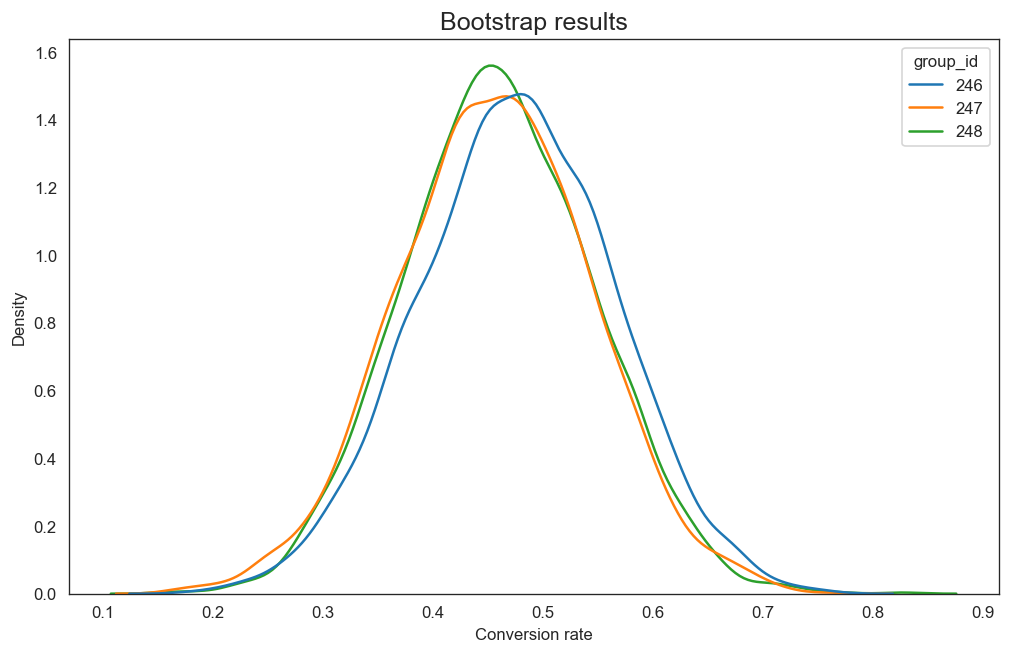

Median conversion rate for group 246 is 0.4762
Median conversion rate for group 247 is 0.4571
Median conversion rate for group 248 is 0.4577


In [47]:
plt.figure(figsize=(10, 6), dpi=120)

sns.kdeplot(data=boot_1d.stack().reset_index(), x='payment_successful', hue='group_id', palette="tab10")

plt.title('Bootstrap results', fontsize=15)
plt.xlabel("Conversion rate")
#plt.ylabel("Bootstrap distributions count")
plt.show()

for i in [246, 247, 248]:
    print(
        f'Median conversion rate for group {i} is {boot_1d.stack().reset_index().query("group_id == @i")["payment_successful"].median():.4}')

На графике конверсий наших 5000 вновь созданных распределений видно, что 246 контрольная группа несколько отличается от второго контроля и тестовой, разница в медианном значении около 2%
Теперь построим график, на котором значениями у нас будет не конверсии групп, а разница `B` относительно общего контроля (AA)

In [48]:
boot_1d.columns = boot_1d.columns.droplevel(0)


In [49]:
boot_1d['diff'] = (boot_1d[248] - (boot_1d[246] + boot_1d[247]) / 2)


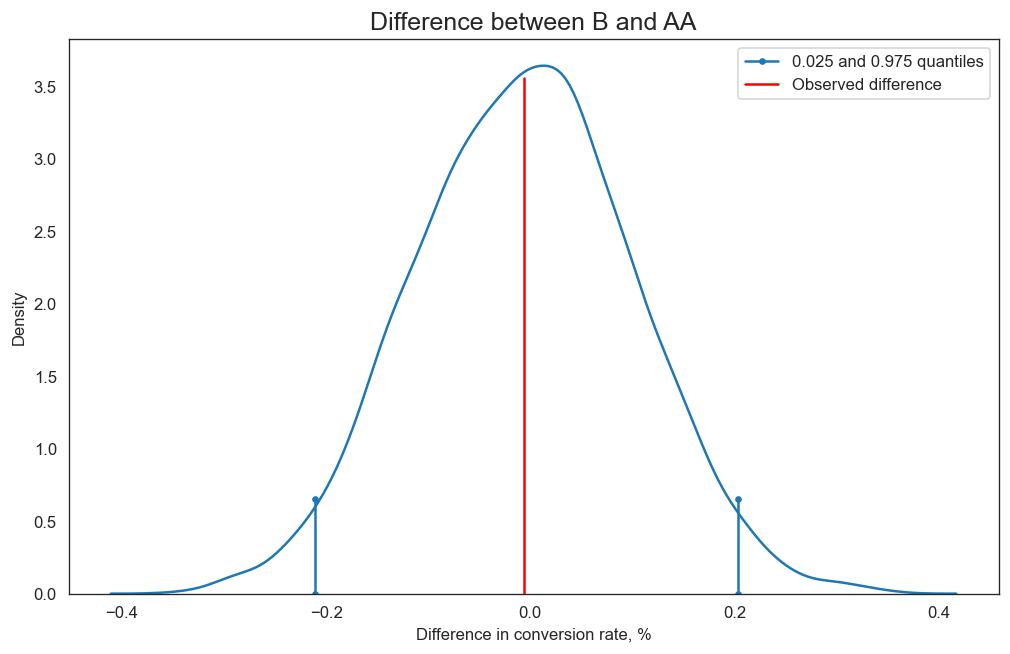

In [50]:
plt.figure(figsize=(10, 6), dpi=120)

sns.kdeplot(data=boot_1d, x='diff', palette="tab10")

plt.title('Difference between B and AA', fontsize=15)
plt.xlabel("Difference in conversion rate, %")
plt.axvline(boot_1d['diff'].quantile(0.025), 0, 0.170, label='0.025 and 0.975 quantiles', marker='.')
plt.axvline(boot_1d['diff'].quantile(0.975), 0, 0.170, marker='.')
plt.axvline(exp_diff / 100, 0, 0.93, color='red', label='Observed difference')
plt.legend(loc='upper right');
plt.show()

In [51]:
f'Вероятность получить в новой случайной подвыборке конверсию в тестовой группе меньше, чем в контрольных - {(boot_1d["diff"] < 0).mean()}'

'Вероятность получить в новой случайной подвыборке конверсию в тестовой группе меньше, чем в контрольных - 0.518'

График почти симметричен относительно нуля, это значит, что нулевую гипотезу о том, что конверсии равны, мы не можем отбросить

## Байес

In [69]:
users.groupby('group_id').agg({'payment_successful': 'sum'})['payment_successful']

group_id
246    1172
247    1136
248    1155
Name: payment_successful, dtype: int64

In [70]:
conversions = users.groupby('group_id').agg({'payment_successful': 'sum'})['payment_successful']
impressions = users.groupby('group_id').agg({'payment_successful': 'count'})['payment_successful']

In [54]:

#This is the known data: impressions and conversions for the Control and Test set
imps_ctrl, convs_ctrl = 2455, 1172
imps_test, convs_test = 2509, 1155

#here we create the Beta functions for the two sets
a_C, b_C = convs_ctrl + 1, imps_ctrl - convs_ctrl + 1
beta_C = beta(a_C, b_C)
a_T, b_T = convs_test + 1, imps_test - convs_test + 1
beta_T = beta(a_T, b_T)

#calculating the lift
lift = (beta_T.mean() - beta_C.mean()) / beta_C.mean()

#calculating the probability for Test to be better than Control
prob = calc_prob_between(beta_T, beta_C)

print(f"Test option lift Conversion Rates by {lift * 100:2.2f}% with {prob * 100:2.1f}% probability")
#output: Test option lift Conversion Rates by 59.68% with 98.2% probability.

Test option lift Conversion Rates by -3.57% with nan% probability.


# Вывод

Мы обозначили точное время проведения эксперимента, изучив распределение записей в логе по часам, и решили считать началом 22:00 31.07
Узнали, что от первого события до оплаты доходит меньше половины пользователей (0.46%), при этом 0.38% процентов пользователей не перешли с главной страницы на страницу каталога, а 0.12% со страницы каталога в корзину. Конверсия с корзины в оплату, впрочем, высокая

A/A/B тест, который мы проанализировали, состоял из 16 гипотез, все из которых не показали значимого изменения
Шрифт, видимо, на пользователей почти не влияет, и уж точно не отпугнёт